# College Football Classifier

 Goal: Take in data for all of 2018's defense, receiving, and rushing records to predict overall TD's

With our project, we aim to see if when data is integrated if we can predict with better accuracy than with a single. The focus of our project is college football stats and if they can be used to accurately predict the number of touchdowns a team scores.
In football, the two main components of the game are offense which are yards gained primarily made up of plays made up of receiving and rushing, and defense, or stops made on the other team or yards allowed. In general, these components (and more) are all important to scoring touchdowns and winning, so statistics from one area of the game will most likely not be as accurate in predicting touchdowns as the three combined.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import re

# 1.) Reading in & Cleaning Defensive, Receiving, and Rushing Data

We first took data for defense, receiving, and rushing from 2018 for all the major Division 1 conferences

In [2]:
#Defensive Data, all brought together.

def_data_list= ["defense_acc.csv", "defense_big12.csv", "defense_american.csv", "defense_bigten.csv", 
                "defense_independent.csv", "defense_mac.csv", "defense_mountainwest.csv", "defense_pac12.csv",
                "defense_sec.csv", "defense_sunbelt.csv"]

df_defense = []

def defense(data):
    df = pd.read_csv("rawdata/" + data) #Reading in all the data from rawdata folder
    td_column = df.groupby(["Team"])["TD"].sum() #Store sum of TD's as a column
    df = df.groupby("Team").mean()
    df["TD"] = td_column #Then, put sum into df so that we have mean of stats and sum of TD's.
    df = df.rename(columns = {"Yds": "Yds_def", "Avg": "Avg_def"})
    return df

for i in def_data_list:
    df = defense(i)
    df_defense.append(df)

defense_df = pd.concat(df_defense)

defense_df.head()

,Int,Yds_def,Avg_def,TD,Solo,Ast,Tot,Sack,YdsL
Team,,,,,,,,,
BC,2.000000,36.777778,16.921111,2,25.111111,19.555556,44.666667,1.111111,7.222222
CLEM,1.333333,36.444444,28.018889,2,31.666667,19.111111,50.777778,1.222222,7.666667
DUKE,1.000000,19.000000,19.000000,1,32.500000,14.000000,46.500000,0.500000,3.250000
FSU,1.714286,17.857143,13.035714,1,31.428571,18.857143,50.285714,0.500000,2.857143
GT,1.222222,25.666667,19.611111,2,22.111111,15.444444,37.555556,0.666667,4.888889


In [3]:
#Receiving Data, all brought together.

rec_data_list= ["receiving_acc.csv", "receiving_big12.csv", "receiving_american.csv", "receiving_bigten.csv", 
                "receiving_independent.csv", "receiving_mac.csv", "receiving_mountainwest.csv", "receiving_pac12.csv",
                "receiving_sec.csv", "receiving_sunbelt.csv"]

df_receiving = []

def receiving(data):
    df = pd.read_csv("rawdata/" + data)
    df["Yds"] = df['Yds'].str.replace(r'\D', '').astype(int) #Yds was brought in as object, changed to float data type. (Weird input)
    df = df.rename(columns = {"Yds": "Yds_rec", "Avg": "Avg_rec"}) #Renamed for receiving 
    td_column = df.groupby(["Team"])["TD"].sum() #Store sum of TD's as a column
    df = df.groupby(["Team"]).mean()
    df["TD"] = td_column #Then, put sum into df so that we have mean of stats and sum of TD's.
    
    return df

for i in rec_data_list:
    df = receiving(i) #Do function for each raw datatable
    df_receiving.append(df) #Add all the pandas datatables to a list (that evenutally is all brought together as receiving_df)


receiving_df = pd.concat(df_receiving)

receiving_df.head()

,Rec,Yds_rec,Avg_rec,TD
Team,,,,
BC,19.750000,263.750000,13.186250,18
CLEM,29.400000,389.800000,11.719000,34
DUKE,34.714286,386.714286,10.890000,28
FSU,27.000000,336.666667,11.692222,20
GT,13.000000,227.000000,17.390000,3


In [4]:
#Rushing Data, all brought together.

rush_data_list= ["rushing_acc.csv", "rushing_big12.csv", "rushing_american.csv", "rushing_bigten.csv", 
                "rushing_independent.csv", "rushing_mac.csv", "rushing_mountainwest.csv", "rushing_pac12.csv",
                "rushing_sec.csv", "rushing_sunbelt.csv"]

df_rushing = []

def rushing(data):
    df = pd.read_csv("rawdata/" + data)
    df["Yds"] = df['Yds'].str.replace(r'\D', '').astype(int) #Yds was brought in as object, changed to float data type. (Weird input)
    df["Gain"] = df["Gain"].str.replace(r'\D', '').astype(int) #Gain is like Yds as well. I think the ',' is throwing it off. (Weird input)
    td_column = df.groupby(["Team"])["TD"].sum() #Store sum of TD's as a column
    df = df.groupby(["Team"]).mean()
    df = df.rename(columns = {"Yds": "Yds_rush", "Avg": "Avg_rush"})
    df["TD"] = td_column #Then, put sum into df so that we have mean of stats and sum of TD's.
    
    return df

for i in rush_data_list:
    df = rushing(i)
    df_rushing.append(df)


rushing_df = pd.concat(df_rushing)

rushing_df.head()

,Att,Gain,Loss,Yds_rush,Avg_rush,TD
Team,,,,,,
BC,63.000000,317.375000,28.625000,288.750000,4.692500,20
CLEM,60.777778,434.888889,24.444444,410.444444,6.036667,45
DUKE,56.750000,284.375000,31.500000,252.875000,4.986250,19
FSU,93.000000,413.666667,37.000000,376.666667,4.163333,8
GT,80.444444,489.111111,27.888889,461.222222,7.107778,46


In [5]:
#Bring all tables together.

master = pd.concat([rushing_df, receiving_df, defense_df], axis = 1) #First, bring all three tables created above together
master = master.groupby(level = 0, axis = 1).sum() #Then, add TD columns to get total TD's by team.
master.head()

,Ast,Att,Avg_def,Avg_rec,Avg_rush,Gain,Int,Loss,Rec,Sack,Solo,TD,Tot,YdsL,Yds_def,Yds_rec,Yds_rush
Team,,,,,,,,,,,,,,,,,
BC,19.555556,63.000000,16.921111,13.186250,4.692500,317.375000,2.000000,28.625000,19.750000,1.111111,25.111111,40.0,44.666667,7.222222,36.777778,263.750000,288.750000
CLEM,19.111111,60.777778,28.018889,11.719000,6.036667,434.888889,1.333333,24.444444,29.400000,1.222222,31.666667,81.0,50.777778,7.666667,36.444444,389.800000,410.444444
DUKE,14.000000,56.750000,19.000000,10.890000,4.986250,284.375000,1.000000,31.500000,34.714286,0.500000,32.500000,48.0,46.500000,3.250000,19.000000,386.714286,252.875000
FSU,18.857143,93.000000,13.035714,11.692222,4.163333,413.666667,1.714286,37.000000,27.000000,0.500000,31.428571,29.0,50.285714,2.857143,17.857143,336.666667,376.666667
GT,15.444444,80.444444,19.611111,17.390000,7.107778,489.111111,1.222222,27.888889,13.000000,0.666667,22.111111,51.0,37.555556,4.888889,25.666667,227.000000,461.222222


<AxesSubplot:ylabel='Frequency'>

<Figure size 432x288 with 0 Axes>

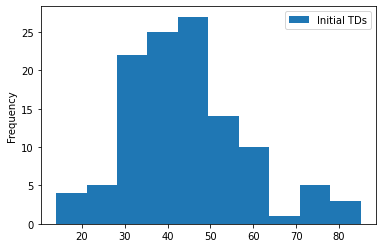

In [37]:
# Initial number of TD's. We can see that outliers exist!

df0 = pd.DataFrame({'Initial TDs':master["TD"]})

plt.figure()

df0.plot.hist(alpha = 1)

In [6]:
#
# Observe the summary statistics of the master data table
#
master.describe()

,Ast,Att,Avg_def,Avg_rec,Avg_rush,Gain,Int,Loss,Rec,Sack,Solo,TD,Tot,YdsL,Yds_def,Yds_rec,Yds_rush
count,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000,116.000000
mean,15.668725,59.794159,10.038169,12.003353,5.564363,320.794547,1.311677,28.904708,25.861837,0.678575,24.738897,44.336207,40.407622,4.372880,15.856067,327.924966,292.418075
std,5.732474,17.611847,6.268573,1.914450,1.841449,100.940814,0.414365,13.793581,7.704053,0.500798,6.865397,13.589602,11.166971,3.279567,9.646167,106.811265,93.467745
min,2.000000,26.166667,-1.750000,8.272500,-0.112000,131.333333,0.384615,6.750000,4.333333,0.000000,7.000000,14.000000,9.000000,0.000000,-1.250000,86.750000,117.888889
25%,11.710714,46.897222,5.370958,10.831458,4.490556,244.555556,1.000000,19.010417,21.482143,0.368750,19.851190,35.000000,31.600000,2.208333,8.867788,262.178571,220.562500
50%,15.422222,56.486111,8.156349,11.860091,5.311286,299.443182,1.333333,26.576389,25.472222,0.559028,25.055556,43.000000,40.942857,3.590278,14.050000,318.207143,276.514286
75%,18.965278,68.625000,13.705000,12.664345,6.231250,388.285714,1.555556,37.107143,30.325000,0.839286,29.031250,51.000000,47.514423,5.784722,21.198052,390.127778,359.804545
max,30.888889,131.500000,29.875000,19.203333,16.688182,620.750000,2.500000,70.250000,52.333333,2.687500,49.000000,85.000000,79.666667,17.250000,39.545455,774.000000,550.500000


In [7]:
#
# More summary info
#
master.info()

<class 'pandas.core.frame.DataFrame'>
Index: 116 entries, BC to USA
Data columns (total 17 columns):
Ast         116 non-null float64
Att         116 non-null float64
Avg_def     116 non-null float64
Avg_rec     116 non-null float64
Avg_rush    116 non-null float64
Gain        116 non-null float64
Int         116 non-null float64
Loss        116 non-null float64
Rec         116 non-null float64
Sack        116 non-null float64
Solo        116 non-null float64
TD          116 non-null float64
Tot         116 non-null float64
YdsL        116 non-null float64
Yds_def     116 non-null float64
Yds_rec     116 non-null float64
Yds_rush    116 non-null float64
dtypes: float64(17)
memory usage: 16.3+ KB


# 2.) Data Exploration

<bound method Grid.add_legend of <seaborn.axisgrid.PairGrid object at 0x129ec9f70>>

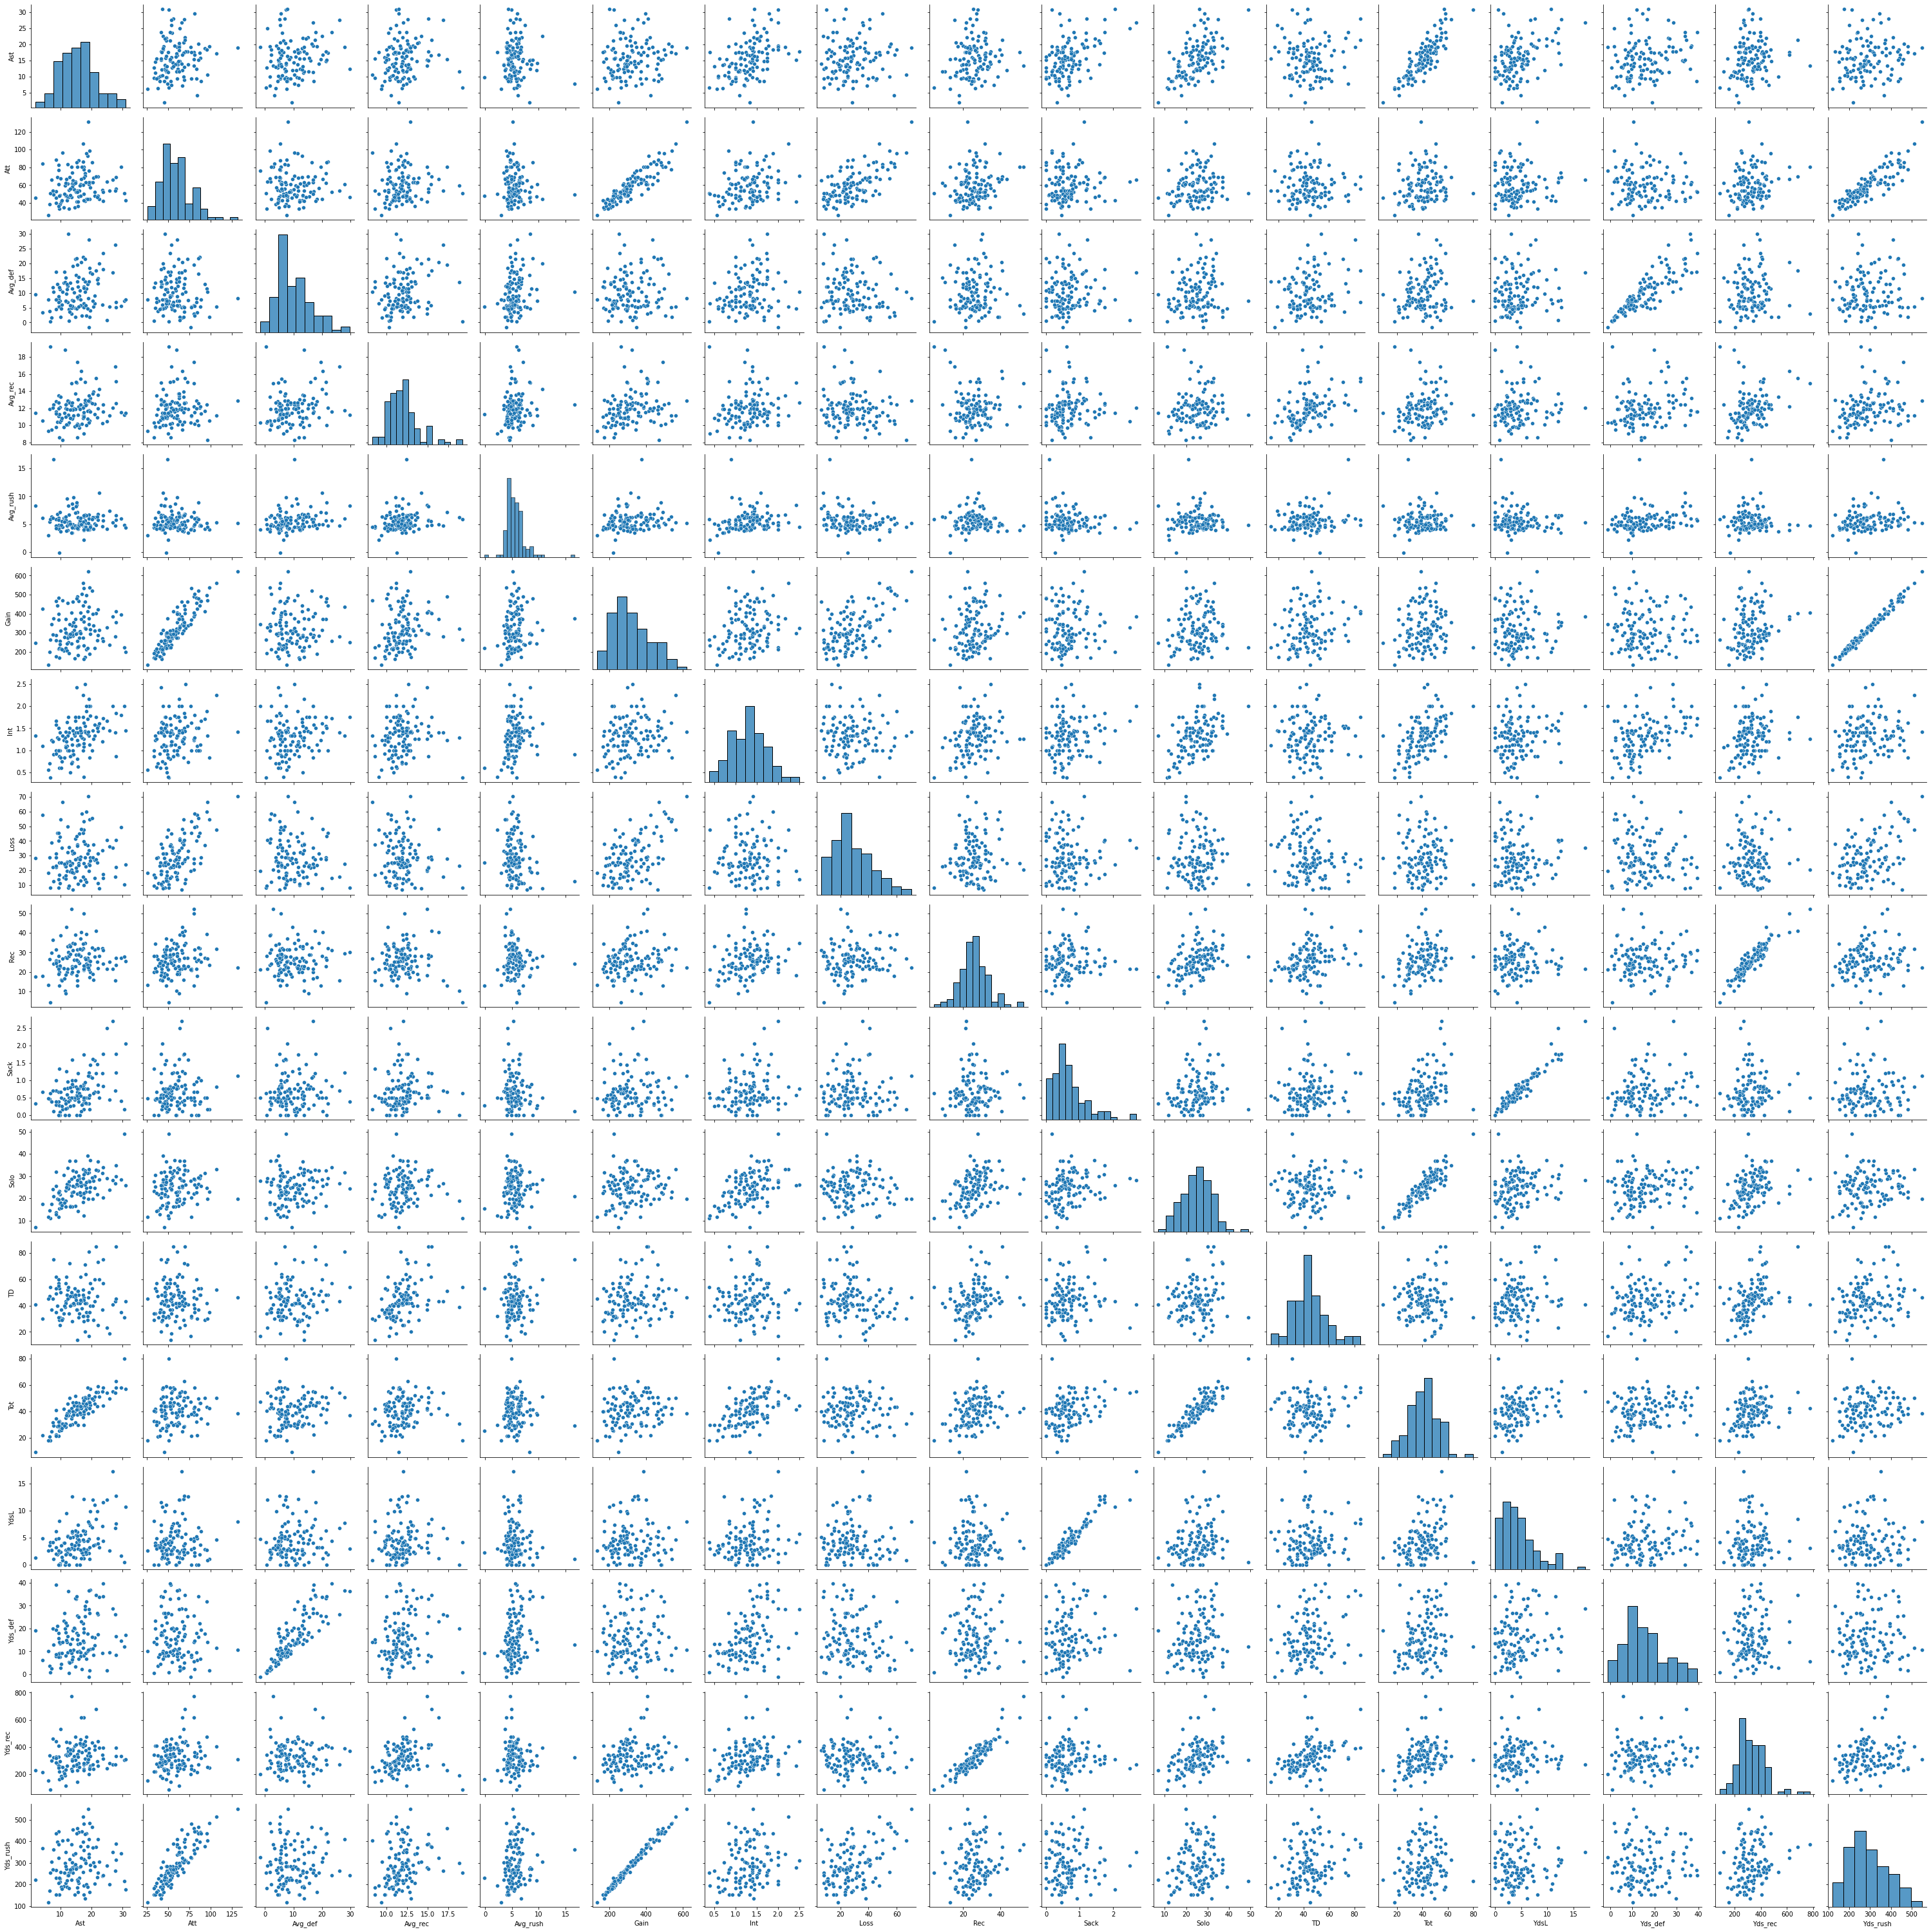

In [40]:
#Now, let's visualize. Any relationships we see?

g = sns.PairGrid(master)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend

In [18]:
#
# Get the conference DF so we can join to rush, receive, and def DFs.
#
raw_data_list= ["defense_acc.csv", "defense_big12.csv", "defense_american.csv", "defense_bigten.csv", 
                "defense_independent.csv", "defense_mac.csv", "defense_mountainwest.csv", "defense_pac12.csv",
                "defense_sec.csv", "defense_sunbelt.csv"]

df_all = []

def all_conference(data):
    df = pd.read_csv("rawdata/" + data) #Reading in all the data from rawdata folder
    df = df.groupby("Team").mean()
    res = re.split("\.|_", data)
    df["Conference"] = res[1].upper()
    return df

for i in raw_data_list:
    df = all_conference(i)
    df_all.append(df)

conference_df = pd.concat(df_all)
conference_df = conference_df.reset_index()
conference_df = conference_df[["Team", "Conference"]]
conference_df

,Team,Conference
0,BC,ACC
1,CLEM,ACC
2,DUKE,ACC
3,FSU,ACC
4,GT,ACC
5,LOU,ACC
6,MIA,ACC
7,NCST,ACC
8,PITT,ACC
9,SYR,ACC


In [67]:
#
# use merge to perform a left join and add the conference data to our
# 3 main tables.
#
conference_rush_df = pd.merge(conference_df, rushing_df, how="left", on="Team")
conference_rec_df = pd.merge(conference_df, receiving_df, how="left", on="Team")
conference_def_df = pd.merge(conference_df, defense_df, how="left", on="Team")
conference_rush_df

,Team,Conference,Att,Gain,Loss,Yds_rush,Avg_rush,TD
0,BC,ACC,63.000000,317.375000,28.625000,288.750000,4.692500,20
1,CLEM,ACC,60.777778,434.888889,24.444444,410.444444,6.036667,45
2,DUKE,ACC,56.750000,284.375000,31.500000,252.875000,4.986250,19
3,FSU,ACC,93.000000,413.666667,37.000000,376.666667,4.163333,8
4,GT,ACC,80.444444,489.111111,27.888889,461.222222,7.107778,46
5,LOU,ACC,48.625000,255.875000,42.875000,213.000000,4.468750,17
6,MIA,ACC,65.714286,386.428571,35.571429,350.857143,5.298571,23
7,NCST,ACC,80.600000,383.600000,24.800000,358.800000,3.886000,24
8,PITT,ACC,68.875000,441.750000,45.250000,396.500000,6.756250,28
9,SYR,ACC,106.400000,559.800000,47.600000,512.200000,5.324000,33


In [ ]:
#
# Reshape data to be suitable for seaborn heatmaps
#
reshape_rush = conference_rush_df.pivot("Conference", "Avg_rush", "TD")
reshape_rec = conference_rec_df.pivot("Conference", "Avg_rec", "TD")
reshape_def = conference_def_df.pivot("Conference", "Avg_def", "TD")
reshape_rush

### Rushing Heatmap

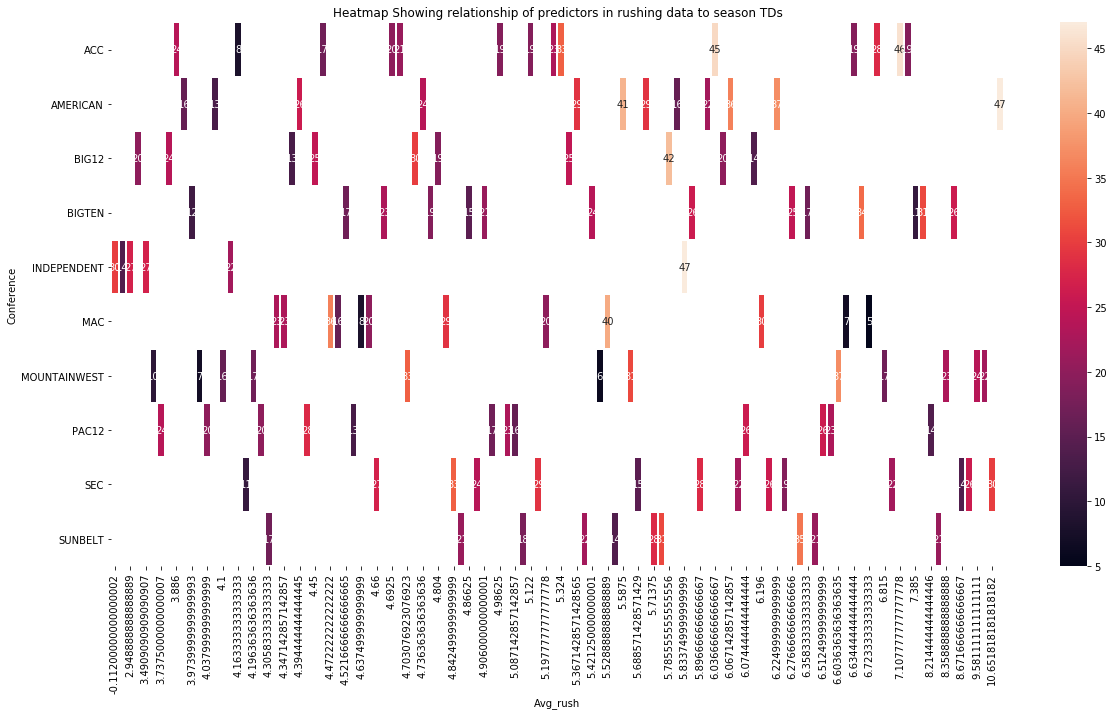

In [72]:
#
# Using a heatmap to visualize rushing predictors
#
plt.figure(figsize = (20, 10)) # Don't really know what this does. Pixels?

#
# Make the heatmap
#
#heat_map = sns.heatmap(conference_rush_df[["Att", "Gain", 'Loss', "Yds_rush", "Avg_rush", "TD"]], linewidth = 1 , annot = True)
heat_map = sns.heatmap(reshape_rush, linewidth = 1, annot = True)

plt.title("Heatmap Showing relationship of predictors in rushing data to season TDs")
plt.show()

### Receiving Heatmap

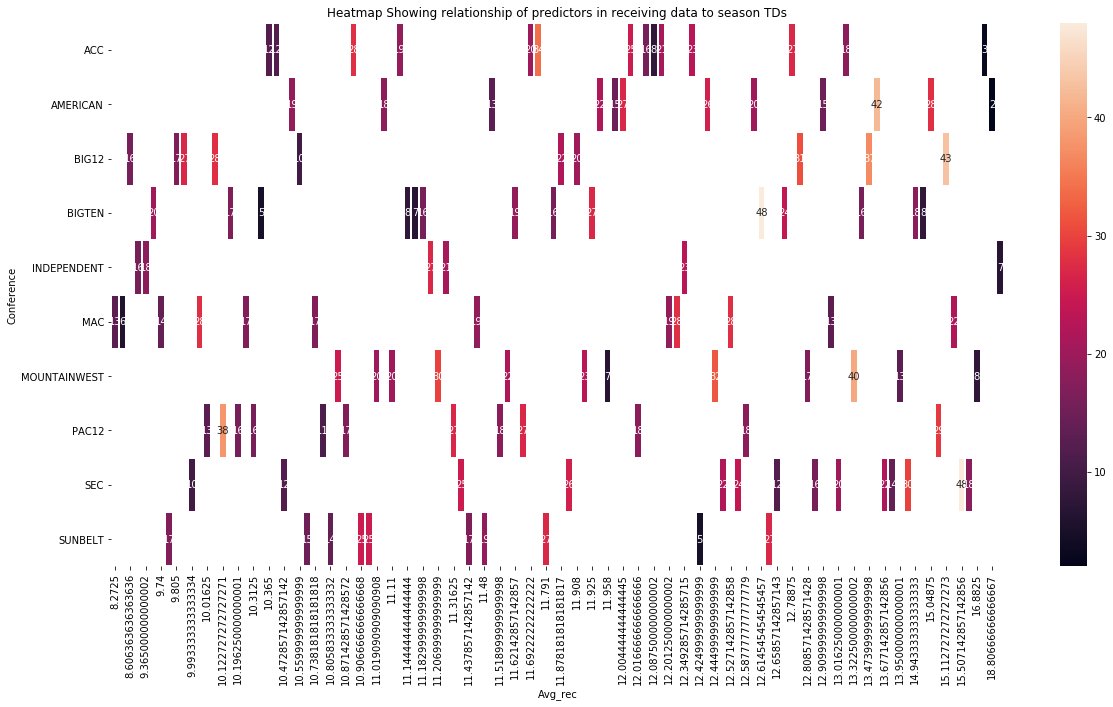

In [70]:
#
# Using a heatmap to visualize receiving predictors
#
plt.figure(figsize = (20, 10)) # Don't really know what this does. Pixels?

#
# Make the heatmap
#
heat_map = sns.heatmap(reshape_rec, linewidth = 1, annot = True)

plt.title("Heatmap Showing relationship of predictors in receiving data to season TDs")
plt.show()

### Defense Heatmap

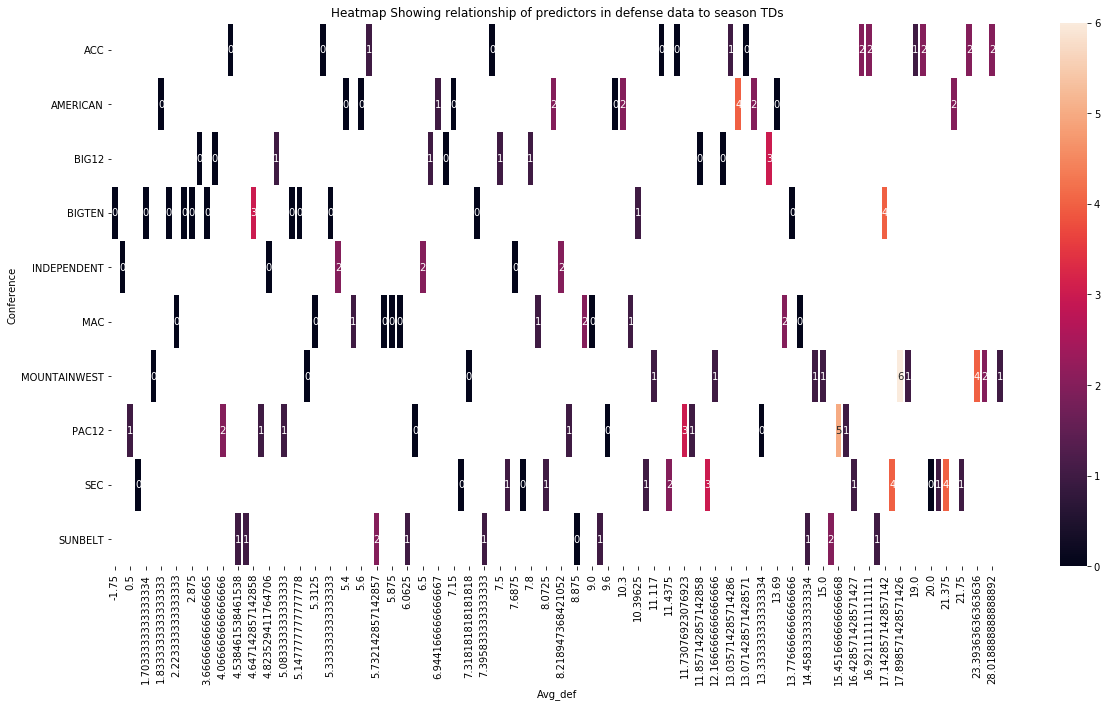

In [71]:
#
# Using a heatmap to visualize defense predictors
#
plt.figure(figsize = (20, 10)) # Don't really know what this does. Pixels?

#
# Make the heatmap
#
heat_map = sns.heatmap(reshape_def, linewidth = 1, annot = True)

plt.title("Heatmap Showing relationship of predictors in defense data to season TDs")
plt.show()

In [42]:
#It's hard to see. Maybe we can use pandas?

master.corr()

#From here, we have several possible options:
# Yds_rec = 0.420190
# Avg_rec = 0.386550
# Yds_def = 0.256788
# Rec = 0.255513
# Yds_rush = 0.241497
# Avg_def = 0.223038	
# Gain = 0.196433	

# Let's use these in the model!


,Ast,Att,Avg_def,Avg_rec,Avg_rush,Gain,Int,Loss,Rec,Sack,Solo,TD,Tot,YdsL,Yds_def,Yds_rec,Yds_rush
Ast,1.000000,0.133819,0.164113,0.138073,-0.058989,0.118163,0.446770,0.040157,0.137938,0.462314,0.567978,0.017740,0.862532,0.425840,0.215711,0.162633,0.118019
Att,0.133819,1.000000,-0.036934,0.089702,-0.065224,0.904568,0.232697,0.653884,0.212977,0.031585,0.123581,0.003674,0.144672,0.030594,-0.060294,0.210813,0.875330
Avg_def,0.164113,-0.036934,1.000000,0.213866,0.234788,0.049399,0.174255,-0.128978,0.008486,0.048526,0.126406,0.223038,0.161960,0.080222,0.855763,0.085462,0.068989
Avg_rec,0.138073,0.089702,0.213866,1.000000,0.195416,0.208122,0.109721,-0.155264,-0.076373,0.047073,0.053571,0.386550,0.103814,0.058171,0.211479,0.242382,0.243834
Avg_rush,-0.058989,-0.065224,0.234788,0.195416,1.000000,0.154915,0.179136,-0.212280,-0.047961,-0.125443,0.002291,0.164870,-0.028873,-0.108712,0.238238,-0.001573,0.185636
Gain,0.118163,0.904568,0.049399,0.208122,0.154915,1.000000,0.229676,0.551243,0.161687,0.022285,0.112509,0.196433,0.129828,0.014336,0.009814,0.211254,0.992258
Int,0.446770,0.232697,0.174255,0.109721,0.179136,0.229676,1.000000,-0.031702,0.250661,0.189391,0.492495,0.005755,0.532129,0.176903,0.414107,0.249813,0.242484
Loss,0.040157,0.653884,-0.128978,-0.155264,-0.212280,0.551243,-0.031702,1.000000,0.080137,0.014517,-0.018821,-0.187846,0.009043,-0.011301,-0.146783,0.032976,0.447853
Rec,0.137938,0.212977,0.008486,-0.076373,-0.047961,0.161687,0.250661,0.080137,1.000000,0.031640,0.387996,0.255513,0.309347,0.015286,0.052834,0.922322,0.155342
Sack,0.462314,0.031585,0.048526,0.047073,-0.125443,0.022285,0.189391,0.014517,0.031640,1.000000,0.224797,0.125010,0.375529,0.962918,0.144914,0.054548,0.018408


# 3.) XGBoost Model

We create a null, optimized, and XGBoost model with 1 data source. Goal is to compare the three and see if we're learning more and more. Maybe add a visualization of a table of some sort here?

## 3a.) Prepare data for null & optimized XGBoost Model

In [43]:
#
# Prune master dataset to variables we want.
#
master_p = master[["Yds_rec", "Avg_rec", "Yds_def", "Rec", "Yds_rush", "Avg_def", "Gain", "TD"]]
master_p.head(5)


,Yds_rec,Avg_rec,Yds_def,Rec,Yds_rush,Avg_def,Gain,TD
Team,,,,,,,,
BC,263.750000,13.186250,36.777778,19.750000,288.750000,16.921111,317.375000,40.0
CLEM,389.800000,11.719000,36.444444,29.400000,410.444444,28.018889,434.888889,81.0
DUKE,386.714286,10.890000,19.000000,34.714286,252.875000,19.000000,284.375000,48.0
FSU,336.666667,11.692222,17.857143,27.000000,376.666667,13.035714,413.666667,29.0
GT,227.000000,17.390000,25.666667,13.000000,461.222222,19.611111,489.111111,51.0


In [44]:
#
# Convert master datatable to a numpy array for easier splitting
#
print("Type of table" + str(type(master)))
master_np = master_p.to_numpy()
print("Type of table" + str(type(master_np)))


Type of table<class 'pandas.core.frame.DataFrame'>
Type of table<class 'numpy.ndarray'>


In [45]:
#
# split data into X and y
#
X = master_np[:,0:7]
Y = master_np[:,7]

## 3b.) Null Model (XGBoost)

In [46]:
#
# Note: Y is the actual, ground truth. Null_pred is the prediction (mean of Y's, or equivalent to random guess).
#
null_pred = [master_p["TD"].mean() for i in Y]
print("Mean for all samples is: {}".format(null_pred[0]))

Mean for all samples is: 44.33620689655172


In [47]:
#
# Now, we can establish baseline scores to compare our models off of.
#

r2score_null = r2_score(Y,null_pred)
mse_null = mean_squared_error(Y,null_pred)
rmse_null = np.sqrt(mean_squared_error(Y,null_pred))
mape_null = mean_absolute_percentage_error(Y,null_pred)*100

print("R2 Score is: {}".format(r2score_null))
print("Mean Squared Error is: {}".format(mse_null))
print("Root Mean Squared Error is: {}".format(rmse_null))
print("Mean Absolute Percent Error is: {}%".format(mape_null)) 

R2 Score is: 0.0
Mean Squared Error is: 183.08524078478004
Root Mean Squared Error is: 13.530899481733654
Mean Absolute Percent Error is: 26.620956022293175%


## 3c.) Optimized Model (XGBoost)

In [48]:
#
# split data into train and test sets. We'll use 20% of the data for testing, and 80% of the
# data for training. This is an 80/20 train/test split.
#
seed = 1337
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

In [49]:
#
# fit model to training data.
# To edit the classifier attributes, put them
# in the XGBClassifier parantheses.
# Possible attributes to edit are
# eta = 0 to 1
# max_depth = any pos integer
# gamma = 0 to 1
# Don't change subsample or colsample unless we really need to.
#
model = XGBRegressor(eta = 0.5, gamma = 0.5, max_depth = 3, subsample = 1, colsample_bytree = 1)
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eta=0.5, gamma=0.5, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.5, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [50]:
#
# make predictions for test data
#
y_pred = model.predict(X_test)
y_pred

array([42.82522 , 63.841103, 37.822414, 39.617325, 39.416874, 36.40445 ,
       45.701984, 65.38749 , 35.77051 , 16.785864, 54.050636, 31.598959,
       63.016003, 52.52361 , 53.727337, 59.663025, 63.424984, 35.753685,
       45.360897, 57.10079 , 31.718367, 34.368946, 40.195747, 26.516653],
      dtype=float32)

In [51]:
#
# Return the ground truth of Y
#

y_test_array = np.array(y_test)
y_test_array

array([48., 49., 31., 30., 38., 32., 42., 44., 47., 30., 45., 43., 43.,
       42., 42., 54., 41., 37., 41., 53., 51., 48., 62., 37.])

<AxesSubplot:ylabel='Frequency'>

<Figure size 432x288 with 0 Axes>

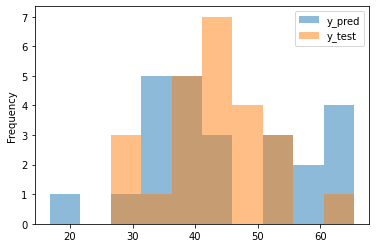

In [52]:
# Visualize pred and test (histogram)

df3 = pd.DataFrame({'y_pred':y_pred, 'y_test':y_test_array})

plt.figure()

df3.plot.hist(alpha = 0.5)

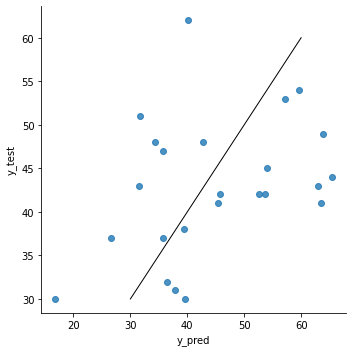

In [53]:
# Visualize pred and test (scatterplot)

sns.lmplot(x='y_pred',y='y_test',data=df3,fit_reg=False,ci=False) 
plt.plot([30, 60], [30, 60], color = 'black', linewidth = 1)

In [54]:
# Evaluation Metrics
# 1.0 is best for r2
# 0 is best for rmse
# Close to 0 is best for mape

r2score_xgb = r2_score(y_test_array,y_pred)
mse_xgb = mean_squared_error(y_test_array,y_pred)
rmse_xgb = np.sqrt(mean_squared_error(y_test_array,y_pred))
mape_xgb = mean_absolute_percentage_error(y_test_array, y_pred)*100

print("R2 Score is: {}".format(r2score_xgb))
print("Mean Squared Error is: {}".format(mse_xgb))
print("Root Mean Squared Error is: {}".format(rmse_xgb))
print("Mean Absolute Percent Error is: {}%".format(mape_xgb))

R2 Score is: -1.5654496543747718
Mean Squared Error is: 156.47461329426127
Root Mean Squared Error is: 12.508981305216714
Mean Absolute Percent Error is: 25.032226419552096%


Text(0.5, 0, 'Feature Importance')

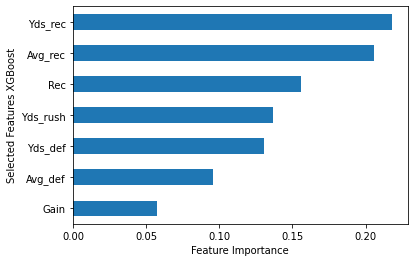

In [55]:
# Visualize Features. Which ones were the most important?

selected_features = np.array(["Yds_rec", "Avg_rec", "Yds_def", "Rec", "Yds_rush", "Avg_def", "Gain"])
feature_importance = np.array(model.feature_importances_)

df_feature_importance = pd.DataFrame({'selected_features':selected_features, 'feature_importance':feature_importance}).sort_values(by = ['feature_importance'])
df_feature_importance
ax = df_feature_importance.plot(x = "selected_features", y = "feature_importance", kind = "barh", legend = None)
ax.set_ylabel("Selected Features XGBoost")
ax.set_xlabel("Feature Importance")


## 3d.) XGBoost with LOOCV

In [56]:

#
# split data into X and y (np this time)
#
X = master_np[:,0:7]
Y = master_np[:,7]

In [57]:
#
# Create cross validation model
#

model_cv = XGBRegressor(eta = 0.5, gamma = 0.5, max_depth = 3, subsample = 1, colsample_bytree = 1)
model_cv.fit(X, Y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eta=0.5, gamma=0.5, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.5, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [58]:
#
# Run LOOCV and return the predicted values from the model
#

k_folds = master_np.shape[0]
kfold = KFold(n_splits=k_folds)
y_pred_xgb_cv = cross_val_predict(model_cv, X, Y, cv=k_folds)
y_pred_xgb_cv

array([54.998116, 57.172173, 44.642464, 45.242317, 49.348335, 33.689236,
       35.439857, 51.693565, 38.400116, 47.313614, 43.049755, 63.32976 ,
       66.76513 , 58.137093, 49.66988 , 47.06839 , 38.187508, 33.013256,
       57.134117, 54.88636 , 30.862772, 35.951195, 39.074154, 43.985264,
       48.386696, 29.588179, 29.510607, 41.761295, 46.359024, 51.211014,
       43.171787, 43.03468 , 63.385883, 42.935253, 50.098515, 59.754986,
       31.265303, 28.729662, 65.210625, 35.50583 , 63.92829 , 60.064434,
       36.682285, 49.700287, 46.346863, 47.295013, 51.37089 , 44.756413,
       26.82882 , 52.984   , 25.076431, 40.708332, 32.772312, 35.442795,
       40.93968 , 25.34706 , 43.832798, 42.658558, 30.369549, 47.78414 ,
       30.84719 , 40.644196, 41.714657, 37.98152 , 16.656816, 71.720894,
       61.213146, 47.42684 , 38.297565, 57.32254 , 42.031284, 69.15264 ,
       48.20155 , 29.798382, 40.37063 , 37.301434, 35.008827, 47.807693,
       44.37522 , 35.61269 , 62.438725, 46.956596, 

In [59]:
#
# Show the ground truth values
#

y_xgb_cv = np.array(Y)
y_xgb_cv

array([40., 81., 48., 29., 51., 25., 41., 46., 40., 52., 31., 42., 46.,
       48., 47., 41., 34., 30., 85., 62., 29., 52., 53., 57., 60., 35.,
       31., 73., 75., 39., 43., 48., 45., 35., 71., 41., 32., 37., 42.,
       37., 49., 41., 19., 38., 31., 72., 50., 46., 17., 47., 54., 45.,
       53., 51., 50., 32., 20., 37., 35., 64., 14., 43., 34., 41., 30.,
       62., 60., 48., 43., 54., 32., 57., 50., 48., 29., 28., 42., 35.,
       75., 25., 44., 45., 31., 37., 57., 40., 43., 32., 34., 44., 45.,
       62., 85., 23., 42., 48., 37., 46., 43., 53., 40., 42., 53., 28.,
       60., 44., 57., 47., 41., 37., 42., 55., 47., 29., 40., 35.])

<AxesSubplot:ylabel='Frequency'>

<Figure size 432x288 with 0 Axes>

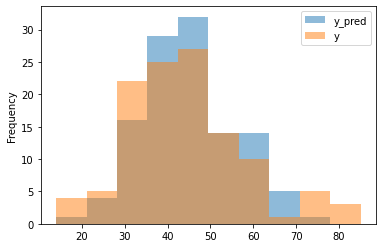

In [60]:
# Visualize pred and test (histogram)

df4 = pd.DataFrame({'y_pred':y_pred_xgb_cv, 'y':y_xgb_cv})

plt.figure()

df4.plot.hist(alpha = 0.5)

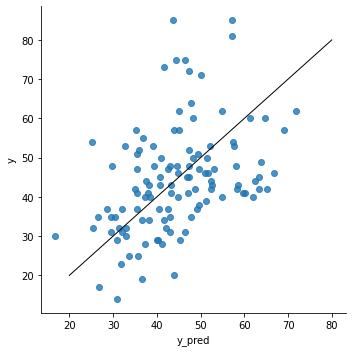

In [108]:
# Visualize pred and test (scatterplot)

sns.lmplot(x='y_pred',y='y',data=df4,fit_reg=False,ci=False) 
plt.plot([20, 80], [20, 80], color = 'black', linewidth = 1)

In [62]:
# Evaluating the model

r2score_xgb_cv = r2_score(y_xgb_cv,y_pred_xgb_cv)
mse_xgb_cv = mean_squared_error(y_xgb_cv,y_pred_xgb_cv)
rmse_xgb_cv = np.sqrt(mean_squared_error(y_xgb_cv,y_pred_xgb_cv))
mape_xgb_cv = mean_absolute_percentage_error(y_xgb_cv, y_pred_xgb_cv)*100

print("R2 Score is: {}".format(r2score_xgb_cv))
print("Mean Squared Error is: {}".format(mse_xgb_cv))
print("Root Mean Squared Error is: {}".format(rmse_xgb_cv))
print("Mean Absolute Percent Error is: {}%".format(mape_xgb_cv))

R2 Score is: 0.025930145266036875
Mean Squared Error is: 178.33781389516335
Root Mean Squared Error is: 13.354318174102463
Mean Absolute Percent Error is: 25.298945757246273%


Text(0.5, 0, 'Feature Importance')

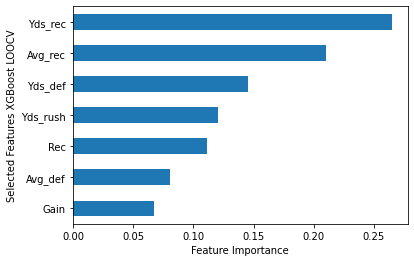

In [63]:
# Visualize Important Features

selected_features = np.array(["Yds_rec", "Avg_rec", "Yds_def", "Rec", "Yds_rush", "Avg_def", "Gain"])
feature_importance = np.array(model_cv.feature_importances_)

df_feature_importance = pd.DataFrame({'selected_features':selected_features, 'feature_importance':feature_importance}).sort_values(by = ['feature_importance'])
df_feature_importance
ax = df_feature_importance.plot(x = "selected_features", y = "feature_importance", kind = "barh", legend = None)
ax.set_ylabel("Selected Features XGBoost LOOCV")
ax.set_xlabel("Feature Importance")

# 4.) Multivariable Linear Regression Model

In [64]:
## MULTIVARIABLE LINEAR REGRESSION ##

x = master_p.drop(['TD'], axis = 1) 
y = master_p['TD']

x.head(5)

,Yds_rec,Avg_rec,Yds_def,Rec,Yds_rush,Avg_def,Gain
Team,,,,,,,
BC,263.750000,13.186250,36.777778,19.750000,288.750000,16.921111,317.375000
CLEM,389.800000,11.719000,36.444444,29.400000,410.444444,28.018889,434.888889
DUKE,386.714286,10.890000,19.000000,34.714286,252.875000,19.000000,284.375000
FSU,336.666667,11.692222,17.857143,27.000000,376.666667,13.035714,413.666667
GT,227.000000,17.390000,25.666667,13.000000,461.222222,19.611111,489.111111


In [65]:
# splitting the data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [66]:
# creating an object of LinearRegression class
LR = LinearRegression()
# fitting the training data
LR.fit(x_train,y_train)

LinearRegression()

In [67]:
# Return predicted values
y_prediction =  LR.predict(x_test)
y_prediction

array([35.38260182, 53.31680322, 33.98799815, 53.41967121, 39.32317878,
       41.49708458, 41.84448764, 38.61170877, 47.29825155, 50.50235512,
       46.45889582, 36.60483477, 46.89230165, 42.92863813, 55.97470437,
       50.44056991, 43.50033157, 43.42156213, 33.84961963, 46.13762776,
       33.16880027, 41.23833085, 49.55641983, 42.26103564])

In [68]:
# Return ground truth values (y_test)
y_test_array = np.array(y_test)
y_test_array

array([37., 51., 19., 49., 31., 46., 42., 32., 32., 42., 72., 31., 42.,
       51., 85., 40., 20., 40., 37., 40., 23., 34., 48., 46.])

<AxesSubplot:ylabel='Frequency'>

<Figure size 432x288 with 0 Axes>

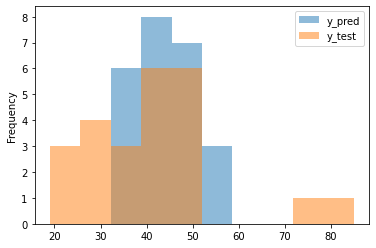

In [69]:
#Visualize pred and test (histogram)

df5 = pd.DataFrame({'y_pred':y_prediction, 'y_test':y_test_array})

plt.figure()

df5.plot.hist(alpha = 0.5)

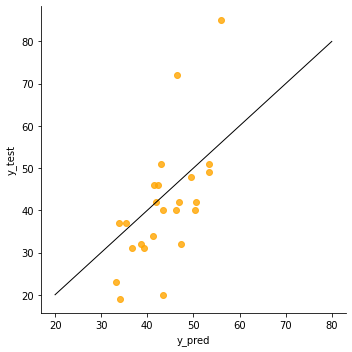

In [106]:
# Visualize pred and test (scatterplot)

sns.lmplot(x='y_pred',y='y_test',data=df5,fit_reg=False,ci=False, scatter_kws = {"color":"orange"}, line_kws = {"color":"orange"}) 
plt.plot([20, 80], [20, 80], color = 'black', linewidth = 1)

In [71]:
# Evaluating the model

r2score_LR = r2_score(y_test_array,y_prediction)
mse_LR = mean_squared_error(y_test_array,y_prediction)
rmse_LR = np.sqrt(mean_squared_error(y_test_array,y_prediction))
mape_LR = mean_absolute_percentage_error(y_test_array, y_prediction)*100

print("R2 Score is: {}".format(r2score_LR))
print("Mean Squared Error is: {}".format(mse_LR))
print("Root Mean Squared Error is: {}".format(rmse_LR))
print("Mean Absolute Percent Error is: {}%".format(mape_LR))

R2 Score is: 0.35441151218875466
Mean Squared Error is: 133.3274724931849
Root Mean Squared Error is: 11.546751599180823
Mean Absolute Percent Error is: 24.608419208438136%


Text(0.5, 0, 'Feature Importance')

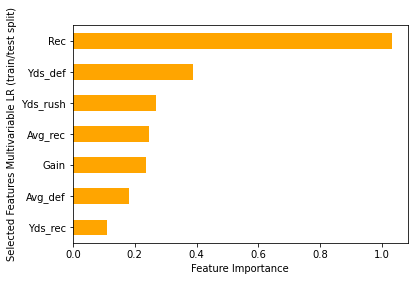

In [72]:
# Visualize Important Features
selected_features_lr = master_p.drop(['TD'], axis = 1).columns 
feature_importance_lr = np.absolute(np.array(LR.coef_)) # Changed all coefficients to be positive for graphing.

df_feature_importance_lr = pd.DataFrame({'selected_features':selected_features_lr, 'feature_importance':feature_importance_lr}).sort_values(by = ['feature_importance'])
df_feature_importance_lr
ax_lr = df_feature_importance_lr.plot(x = "selected_features", y = "feature_importance", kind = "barh", legend = None, color = "orange")
ax_lr.set_ylabel("Selected Features Multivariable LR (train/test split)")
ax_lr.set_xlabel("Feature Importance")

## 4a.) LOOCV for Multivariable Linear Regression

In [73]:
# x and y already defined above

k_folds = x.shape[0]
LR_CV = LinearRegression()

k_folds

116

In [74]:
# Return Predicted Values

y_prediction_cv = cross_val_predict(LR_CV, x, y, cv=k_folds)
y_prediction_cv

array([47.49784406, 54.59547369, 37.42546777, 45.6818993 , 54.04513258,
       36.44037385, 44.79766228, 56.5641836 , 42.13935708, 50.31856267,
       40.12014739, 47.05139372, 42.61565698, 46.42522071, 37.19067383,
       43.62190462, 37.17685222, 32.94806241, 57.27597588, 46.17879667,
       36.75608352, 40.81052528, 43.2447506 , 54.08475924, 47.58775179,
       34.85099846, 36.17003397, 49.71089219, 51.81621275, 47.06330231,
       43.44170679, 42.31354384, 51.37192149, 40.18738998, 58.72569755,
       44.22397443, 38.75511589, 30.56684852, 56.6966618 , 47.7762638 ,
       50.04928355, 82.24498406, 32.39935201, 37.04779835, 40.36268464,
       46.77084258, 50.59057389, 41.01547853, 36.41174227, 56.95607956,
       29.41540192, 33.90511486, 46.12855054, 42.56635009, 37.97585291,
       30.19769251, 41.7139994 , 34.05596836, 41.4179075 , 50.28663974,
       27.96651454, 39.47371451, 27.66475515, 37.55216065, 26.67342707,
       53.76272863, 48.00961914, 51.98954498, 53.25036371, 51.68

In [75]:
# Fit model (Mostly so that we can refer to coef_ method in LR_CV when visualizing feature importance)

LR_CV.fit(x, y)

LinearRegression()

In [76]:
# Print out ground truth

y_test_cv = np.array(y)
y_test_cv

array([40., 81., 48., 29., 51., 25., 41., 46., 40., 52., 31., 42., 46.,
       48., 47., 41., 34., 30., 85., 62., 29., 52., 53., 57., 60., 35.,
       31., 73., 75., 39., 43., 48., 45., 35., 71., 41., 32., 37., 42.,
       37., 49., 41., 19., 38., 31., 72., 50., 46., 17., 47., 54., 45.,
       53., 51., 50., 32., 20., 37., 35., 64., 14., 43., 34., 41., 30.,
       62., 60., 48., 43., 54., 32., 57., 50., 48., 29., 28., 42., 35.,
       75., 25., 44., 45., 31., 37., 57., 40., 43., 32., 34., 44., 45.,
       62., 85., 23., 42., 48., 37., 46., 43., 53., 40., 42., 53., 28.,
       60., 44., 57., 47., 41., 37., 42., 55., 47., 29., 40., 35.])

<AxesSubplot:ylabel='Frequency'>

<Figure size 432x288 with 0 Axes>

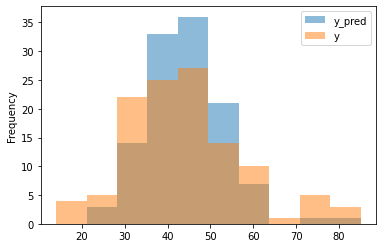

In [77]:
#Visualize pred and test (histogram)

df6 = pd.DataFrame({'y_pred':y_prediction_cv, 'y':y_test_cv})

plt.figure()

df6.plot.hist(alpha = 0.5)

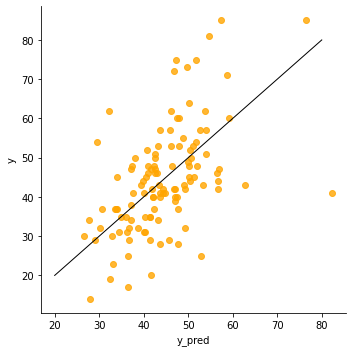

In [104]:
# Visualize pred and test (scatterplot)

sns.lmplot(x='y_pred',y='y',data=df6,fit_reg=False,ci=False, scatter_kws = {"color":"orange"}, line_kws = {"color":"orange"}) 
plt.plot([20, 80], [20, 80], color = 'black', linewidth = 1)

In [79]:
# Evaluating the model

r2score_LR_CV = r2_score(y_test_cv,y_prediction_cv)
mse_LR_CV = mean_squared_error(y_test_cv,y_prediction_cv)
rmse_LR_CV = np.sqrt(mean_squared_error(y_test_cv,y_prediction_cv))
mape_LR_CV = mean_absolute_percentage_error(y_test_cv, y_prediction_cv)*100

print("R2 Score is: {}".format(r2score_LR_CV))
print("Mean Squared Error is: {}".format(mse_LR_CV))
print("Root Mean Squared Error is: {}".format(rmse_LR_CV))
print("Mean Absolute Percent Error is: {}%".format(mape_LR_CV))

R2 Score is: 0.2602553277838977
Mean Squared Error is: 135.43633143194327
Root Mean Squared Error is: 11.637711606322924
Mean Absolute Percent Error is: 22.03634224106098%


Text(0.5, 0, 'Feature Importance')

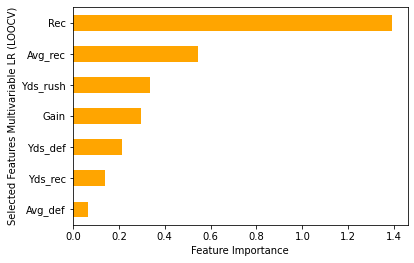

In [80]:
# Visualize Important Features
selected_features_lr = master_p.drop(['TD'], axis = 1).columns 
feature_importance_lr = np.absolute(np.array(LR_CV.coef_)) # Changed all coefficients to be positive for graphing. Also, changed to LR_CV model.

df_feature_importance_lr = pd.DataFrame({'selected_features':selected_features_lr, 'feature_importance':feature_importance_lr}).sort_values(by = ['feature_importance'])
df_feature_importance_lr
ax_lr = df_feature_importance_lr.plot(x = "selected_features", y = "feature_importance", kind = "barh", legend = None, color = "orange")
ax_lr.set_ylabel("Selected Features Multivariable LR (LOOCV)")
ax_lr.set_xlabel("Feature Importance")

# 5.) Aggregate Models Together (LOOCV models)

## 5a.) Max Aggregation

In [81]:
# First, make the maximum predicted value from our two models (either the XGBoost or LR model)

max_pred = np.maximum(y_prediction_cv, y_pred_xgb_cv)
max_pred

array([54.99811554, 57.17217255, 44.64246368, 45.6818993 , 54.04513258,
       36.44037385, 44.79766228, 56.5641836 , 42.13935708, 50.31856267,
       43.0497551 , 63.32976151, 66.76512909, 58.13709259, 49.66987991,
       47.06838989, 38.18750763, 33.01325607, 57.27597588, 54.88636017,
       36.75608352, 40.81052528, 43.2447506 , 54.08475924, 48.38669586,
       34.85099846, 36.17003397, 49.71089219, 51.81621275, 51.21101379,
       43.44170679, 43.03467941, 63.38588333, 42.93525314, 58.72569755,
       59.75498581, 38.75511589, 30.56684852, 65.21062469, 47.7762638 ,
       63.92829132, 82.24498406, 36.68228531, 49.70028687, 46.34686279,
       47.29501343, 51.37089157, 44.75641251, 36.41174227, 56.95607956,
       29.41540192, 40.70833206, 46.12855054, 42.56635009, 40.93967819,
       30.19769251, 43.832798  , 42.65855789, 41.4179075 , 50.28663974,
       30.84719086, 40.64419556, 41.71465683, 37.98152161, 26.67342707,
       71.72089386, 61.21314621, 51.98954498, 53.25036371, 57.32

<AxesSubplot:ylabel='Frequency'>

<Figure size 432x288 with 0 Axes>

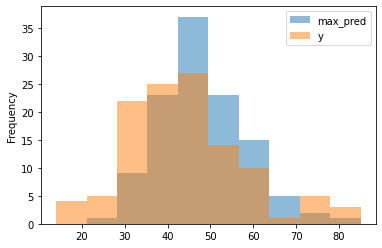

In [82]:
# Then, we can visualize pred and test (histogram)

df7 = pd.DataFrame({'max_pred':max_pred, 'y':y_test_cv})

plt.figure()

df7.plot.hist(alpha = 0.5)

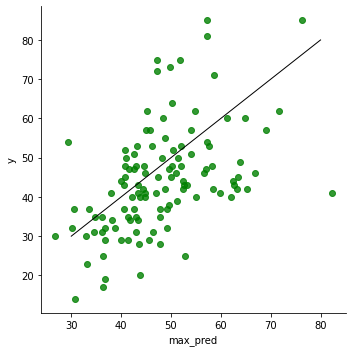

In [103]:
# We can also visualize pred and test using a scatterplot

sns.lmplot(x='max_pred',y='y',data=df7,fit_reg=False,ci=False, scatter_kws = {"color":"green"}, line_kws = {"color":"green"}) 
plt.plot([30, 80], [30, 80], color = 'black', linewidth = 1)

In [84]:
# Finally, we can evaluate the model (max)

r2score_max = r2_score(y_test_cv,max_pred)
mse_max = mean_squared_error(y_test_cv,max_pred)
rmse_max = np.sqrt(mean_squared_error(y_test_cv,max_pred))
mape_max = mean_absolute_percentage_error(y_test_cv,max_pred)*100

print("R2 Score is: {}".format(r2score_max))
print("Mean Squared Error is: {}".format(mse_max))
print("Root Mean Squared Error is: {}".format(rmse_max))
print("Mean Absolute Percent Error is: {}%".format(mape_max))

R2 Score is: 0.1110482758446023
Mean Squared Error is: 162.75394046303637
Root Mean Squared Error is: 12.75750526016103
Mean Absolute Percent Error is: 26.03188794775231%


## 5b.) Average Aggregation

In [85]:
# First, make get the mean predicted value from our two models (either the XGBoost or LR model)

mean_pred = (y_prediction_cv + y_pred_xgb_cv) / 2
mean_pred

array([51.2479798 , 55.88382312, 41.03396573, 45.46210825, 51.69673392,
       35.06480477, 40.11875988, 54.12887448, 40.26973652, 48.81608828,
       41.58495124, 55.19057761, 54.69039304, 52.28115665, 43.43027687,
       45.34514725, 37.68217993, 32.98065924, 57.2050465 , 50.53257842,
       33.80942775, 38.38086002, 41.15945225, 49.03501153, 47.98722383,
       32.21958855, 32.84032037, 45.73609375, 49.0876184 , 49.13715805,
       43.30674703, 42.67411163, 57.37890241, 41.56132156, 54.41210605,
       51.98948012, 35.01020927, 29.64825523, 60.95364325, 41.64104633,
       56.98878744, 71.15470906, 34.54081866, 43.37404261, 43.35477372,
       47.032928  , 50.98073273, 42.88594552, 31.62028077, 54.97004036,
       27.2459166 , 37.30672346, 39.45043135, 39.00457244, 39.45776555,
       27.77237588, 42.7733987 , 38.35726313, 35.89372815, 49.03539064,
       29.4068527 , 40.05895503, 34.68970599, 37.76684113, 21.66512178,
       62.74181124, 54.61138268, 49.70819336, 45.77396459, 54.50

<AxesSubplot:ylabel='Frequency'>

<Figure size 432x288 with 0 Axes>

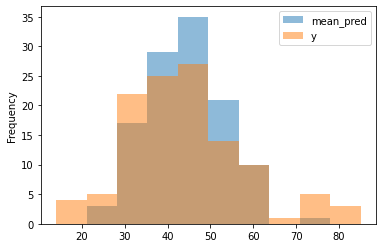

In [86]:
# Then, we can visualize pred and test

df8 = pd.DataFrame({'mean_pred':mean_pred, 'y':y_test_cv})

plt.figure()

df8.plot.hist(alpha = 0.5)

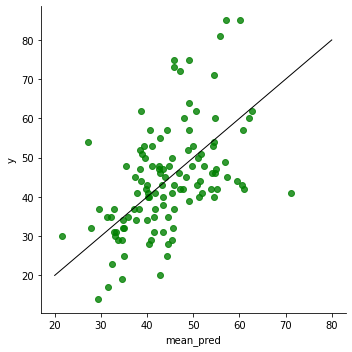

In [109]:
# We can also visualize pred and test using a scatterplot

sns.lmplot(x='mean_pred',y='y',data=df8,fit_reg=False,ci=False, scatter_kws = {"color":"green"}, line_kws = {"color":"green"})
plt.plot([20, 80], [20, 80], color = 'black', linewidth = 1) 

In [88]:
# Finally, we can evaluate the model (mean)

r2score_mean = r2_score(y_test_cv,mean_pred)
mse_mean = mean_squared_error(y_test_cv,mean_pred)
rmse_mean = np.sqrt(mean_squared_error(y_test_cv,mean_pred))
mape_mean = mean_absolute_percentage_error(y_test_cv,mean_pred)*100

print("R2 Score is: {}".format(r2score_mean))
print("Mean Squared Error is: {}".format(mse_mean))
print("Root Mean Squared Error is: {}".format(rmse_mean))
print("Mean Absolute Percent Error is: {}%".format(mape_mean))

R2 Score is: 0.2495600422295512
Mean Squared Error is: 137.3944803629228
Root Mean Squared Error is: 11.721539163562214
Mean Absolute Percent Error is: 22.16078293216367%


## 5c.) Minimum Aggregation

In [89]:
# First, make get the minimum predicted value from our two models (either the XGBoost or LR model)

min_pred = np.minimum(y_prediction_cv, y_pred_xgb_cv)
min_pred

array([47.49784406, 54.59547369, 37.42546777, 45.2423172 , 49.34833527,
       33.68923569, 35.43985748, 51.69356537, 38.40011597, 47.31361389,
       40.12014739, 47.05139372, 42.61565698, 46.42522071, 37.19067383,
       43.62190462, 37.17685222, 32.94806241, 57.13411713, 46.17879667,
       30.86277199, 35.95119476, 39.0741539 , 43.98526382, 47.58775179,
       29.58817863, 29.51060677, 41.76129532, 46.35902405, 47.06330231,
       43.17178726, 42.31354384, 51.37192149, 40.18738998, 50.09851456,
       44.22397443, 31.26530266, 28.72966194, 56.6966618 , 35.50582886,
       50.04928355, 60.06443405, 32.39935201, 37.04779835, 40.36268464,
       46.77084258, 50.59057389, 41.01547853, 26.82881927, 52.98400116,
       25.07643127, 33.90511486, 32.77231216, 35.4427948 , 37.97585291,
       25.34705925, 41.7139994 , 34.05596836, 30.3695488 , 47.78414154,
       27.96651454, 39.47371451, 27.66475515, 37.55216065, 16.65681648,
       53.76272863, 48.00961914, 47.42684174, 38.29756546, 51.68

<AxesSubplot:ylabel='Frequency'>

<Figure size 432x288 with 0 Axes>

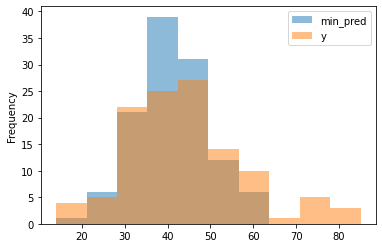

In [90]:
# Then, we can visualize pred and test

df9 = pd.DataFrame({'min_pred':min_pred, 'y':y_test_cv})

plt.figure()

df9.plot.hist(alpha = 0.5)

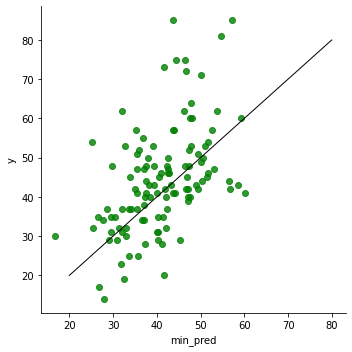

In [91]:
# We can also visualize pred and test using a scatterplot

sns.lmplot(x='min_pred',y='y',data=df9,fit_reg=False,ci=False, scatter_kws = {"color":"green"}, line_kws = {"color":"green"}) 
plt.plot([20, 80], [20, 80], color = 'black', linewidth = 1)

In [92]:
# Finally, we can evaluate the model (min)

r2score_min = r2_score(y_test_cv,min_pred)
mse_min = mean_squared_error(y_test_cv,min_pred)
rmse_min = np.sqrt(mean_squared_error(y_test_cv,min_pred))
mape_min = mean_absolute_percentage_error(y_test_cv,min_pred)*100

print("R2 Score is: {}".format(r2score_min))
print("Mean Squared Error is: {}".format(mse_min))
print("Root Mean Squared Error is: {}".format(rmse_min))
print("Mean Absolute Percent Error is: {}%".format(mape_min))

R2 Score is: 0.17513719720533227
Mean Squared Error is: 151.02020486407028
Root Mean Squared Error is: 12.289027824204414
Mean Absolute Percent Error is: 21.303400050554945%


# 6.) Performance Table for Each Model

In [93]:
# Below creates a table with the results of every model

combined_metrics = {'Model_Name': ["Null", "XGBoost", "XGBoost w/ LOOCV", "LR", "LR w/ LOOCV", "Max LR & XGBoost LOOCV", "Mean LR & XGBoost LOOCV", "Min LR & XGBoost LOOCV"], 
                    'R2_Score': [r2score_null, r2score_xgb, r2score_xgb_cv, r2score_LR, r2score_LR_CV, r2score_max, r2score_mean, r2score_min], 
                    'MSE': [mse_null, mse_xgb, mse_xgb_cv, mse_LR, mse_LR_CV, mse_max, mse_mean, mse_min],
                    "RMSE": [rmse_null, rmse_xgb, rmse_xgb_cv, rmse_LR, rmse_LR_CV, rmse_max, rmse_mean, rmse_min],
                    "MAPE": [mape_null, mape_xgb, mape_xgb_cv, mape_LR, mape_LR_CV, mape_max, mape_mean, mape_min]}

combined_metrics_df = pd.DataFrame(data=combined_metrics)

combined_metrics_df



,Model_Name,R2_Score,MSE,RMSE,MAPE
0,Null,0.000000,183.085241,13.530899,26.620956
1,XGBoost,-1.565450,156.474613,12.508981,25.032226
2,XGBoost w/ LOOCV,0.025930,178.337814,13.354318,25.298946
3,LR,0.354412,133.327472,11.546752,24.608419
4,LR w/ LOOCV,0.260255,135.436331,11.637712,22.036342
5,Max LR & XGBoost LOOCV,0.111048,162.753940,12.757505,26.031888
6,Mean LR & XGBoost LOOCV,0.249560,137.394480,11.721539,22.160783
7,Min LR & XGBoost LOOCV,0.175137,151.020205,12.289028,21.303400


# 7.) MAPE for Each Conference (Min LR & XGBoost LOOCV model)

In [94]:
# Below Maps College Football teams with their respective conference. From here, we can measure the prediction accuracy of 
# each conference and see if there were any discrepencies.

raw_data_list= ["defense_acc.csv", "defense_big12.csv", "defense_american.csv", "defense_bigten.csv", 
                "defense_independent.csv", "defense_mac.csv", "defense_mountainwest.csv", "defense_pac12.csv",
                "defense_sec.csv", "defense_sunbelt.csv"]

df_all = []

def all_conference(data):
    df = pd.read_csv("rawdata/" + data) #Reading in all the data from rawdata folder
    df = df.groupby("Team").mean()
    res = re.split("\.|_", data)
    df["Conference"] = res[1].upper()
    return df

for i in raw_data_list:
    df = all_conference(i)
    df_all.append(df)

conference_df = pd.concat(df_all)
conference_df = conference_df.reset_index()
conference_df = conference_df[["Team", "Conference"]]
conference_df

,Team,Conference
0,BC,ACC
1,CLEM,ACC
2,DUKE,ACC
3,FSU,ACC
4,GT,ACC
...,...,...
111,LA,SUNBELT
112,TROY,SUNBELT
113,TXST,SUNBELT
114,ULM,SUNBELT


In [95]:
## Here, we find the MAPE of each conference and map conference to MAPE value from the Min LR & XGBoost LOOCV model.

conference_df["MIN_PRED"] = min_pred # Adding min_pred to conference_df dataframe
conference_df["Y"] = y_test_cv       # Adding ground truth to conference_df dataframe

conference_list = list(conference_df["Conference"].unique())  # Stores conference names
conference_mape = []                                          # Placeholder to eventually store MAPE values

for i in conference_list:
    temp_df = conference_df[conference_df["Conference"] == i]  # Creates temp dataframe of individual confernce
    conference_mape.append(mean_absolute_percentage_error(temp_df["Y"].to_numpy(), temp_df["MIN_PRED"].to_numpy())*100) # Appends MAPE value to conference_MAPE

conference_mape_dict = {"Conference":conference_list, "MAPE":conference_mape} #Here, we create a dictionary out of two lists
conference_mape_df = pd.DataFrame(conference_mape_dict).sort_values(by = ['MAPE']) #Then, we make the final dataframe mapping conference to MAPE value
conference_mape_df


,Conference,MAPE
7,PAC12,14.368839
9,SUNBELT,15.138148
2,AMERICAN,18.428255
0,ACC,18.458015
1,BIG12,19.113231
8,SEC,20.361747
3,BIGTEN,23.796824
6,MOUNTAINWEST,24.809848
5,MAC,30.753262
4,INDEPENDENT,31.954329


Text(0.5, 0, 'Conference')

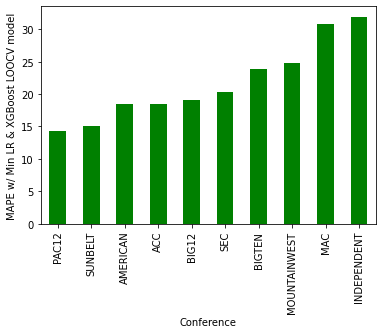

In [96]:
# Finally, the MAPE and Conference values are plotted 
ax_conf = conference_mape_df.plot(x = "Conference", y = "MAPE", kind = "bar", legend = None, color = "green")
ax_conf.set_ylabel("MAPE w/ Min LR & XGBoost LOOCV model")
ax_conf.set_xlabel("Conference")